# Titanic Non-Time Series Data Imputation

The main objective of this notebook is to detect missing values and then impute them using various techniques.

# Data
For this notebook practical I am using publically avaiable dataset from kaggle. For more about
this dataset visit below link as well as for downloading.
- <a href="https://www.kaggle.com/c/titanic/data">Titanic Dataset</a>

# Library Imports

In [114]:
# importing libraries for working with libraries
import os
import pandas as pd 
import numpy as np

# data visualizing libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from bokeh.io import output_notebook
from bokeh.io import show
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure

# ml library
import sklearn
from sklearn.impute import SimpleImputer

# lib for counting missing values
import missingno as msno

# Dataset to Dataframe

In [115]:
#listing files in dataset
file_path = 'OneDrive/DataImputation/titanic'
os.listdir(file_path)

['gender_submission.csv', 'test.csv', 'train.csv']

In [116]:
#let's read the data and print shape of train and test data
train_samples = pd.read_csv(file_path + '/train.csv')
test_samples = pd.read_csv(file_path + '/test.csv')

print('Training Samples Shape: {} \nTesting Samples Shape: {}'.format(train_samples.shape, test_samples.shape))

Training Samples Shape: (891, 12) 
Testing Samples Shape: (418, 11)


In [117]:
#Let's examine the head(first 5 rows) of train samples to see if any missing values
train_samples.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Plotting Target Labels(Expected Output)

In [118]:
# Let's try to plot the target column in our case its survived
output_notebook()
labels = ['Survived', 'Unsurvived']
count = [ train_samples[train_samples.Survived == 0].Survived.count(), train_samples[train_samples.Survived == 1].Survived.count() ] 

source = ColumnDataSource(data=dict(labels=labels, count=count))
p = figure(x_range=labels, height=300, title="Target Counts")
p.vbar(x='labels', top='count', width=0.5, source=source, legend_field="labels",
       line_color='white')
p.legend.orientation = "horizontal"
p.legend.location = "top_right"
show(p)

Loading BokehJS ...

# Detecting Missing Values

In [119]:
def get_missing_values(df):
    """
    This function takes in a data frame and returns the table with columns that have missing values
    """
    missing_values = df.isnull().sum()
    missing_values_percent = 100 * missing_values / len(df)
    missing_values_df = pd.concat([missing_values, missing_values_percent], axis=1)
    missing_values_df = missing_values_df.rename(columns = {0 : 'Missing Values', 1 : '% of missing values'})
    missing_values_df = missing_values_df[missing_values_df.iloc[:, 1] != 0].round(1)
    
    print("Your data frame has " + str(df.shape[1]) + "columns.\n")
    print("Data is missing from " + str(missing_values_df.shape[0]) + " columns.")
    
    return missing_values_df

In [120]:
missing_from_training_samples = get_missing_values(train_samples)
missing_from_training_samples

Your data frame has 12columns.

Data is missing from 3 columns.


,Missing Values,% of missing values
Age,177,19.9
Cabin,687,77.1
Embarked,2,0.2


In [121]:
missing_from_testing_samples = get_missing_values(test_samples)
missing_from_testing_samples

Your data frame has 11columns.

Data is missing from 3 columns.


,Missing Values,% of missing values
Age,86,20.6
Fare,1,0.2
Cabin,327,78.2


## Detecting Missing Values graphically using missingno lib

<AxesSubplot:>

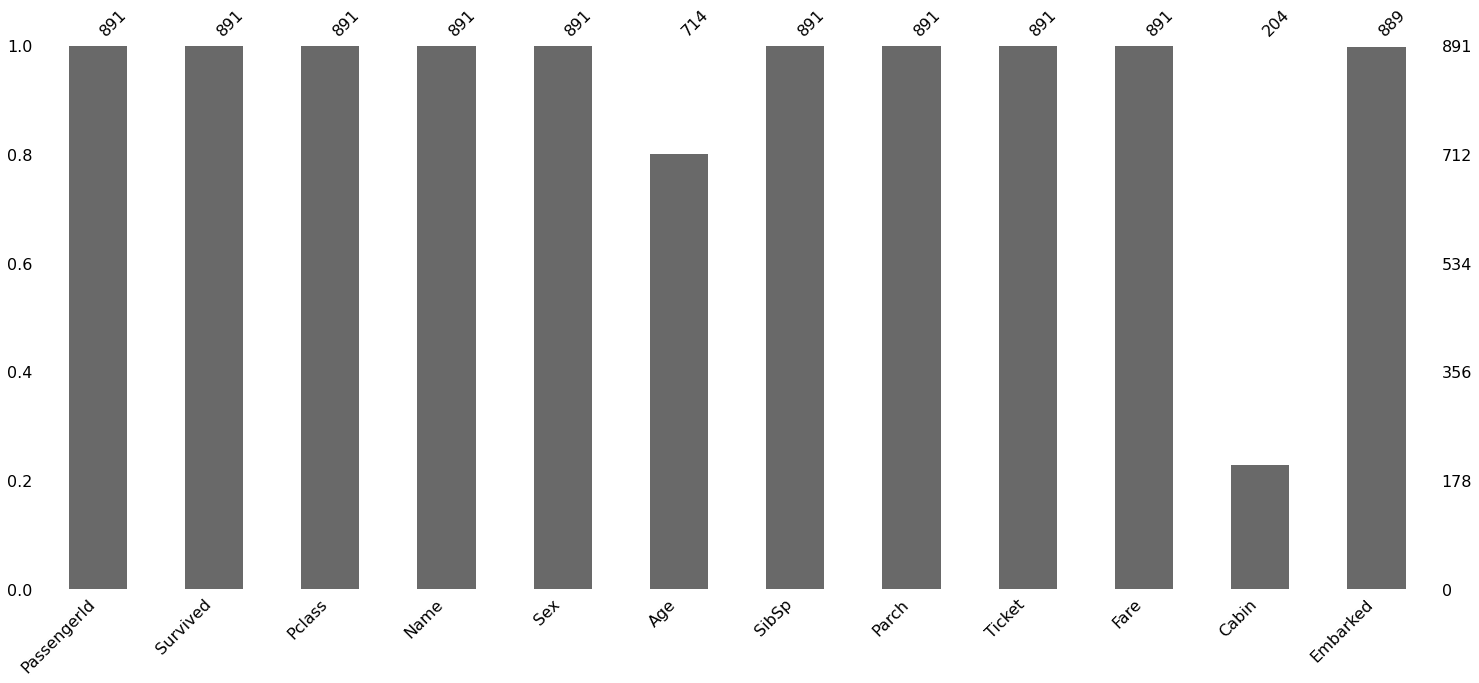

In [122]:
msno.bar(train_samples)

Above bar chart provides a quick view of missing values such as age, cabin and, embarked. Now let's dig a little deeper into missing values seeing how frequent they are missing to categories these values into one of three as shown below. These Definitions are from Wikipedia.

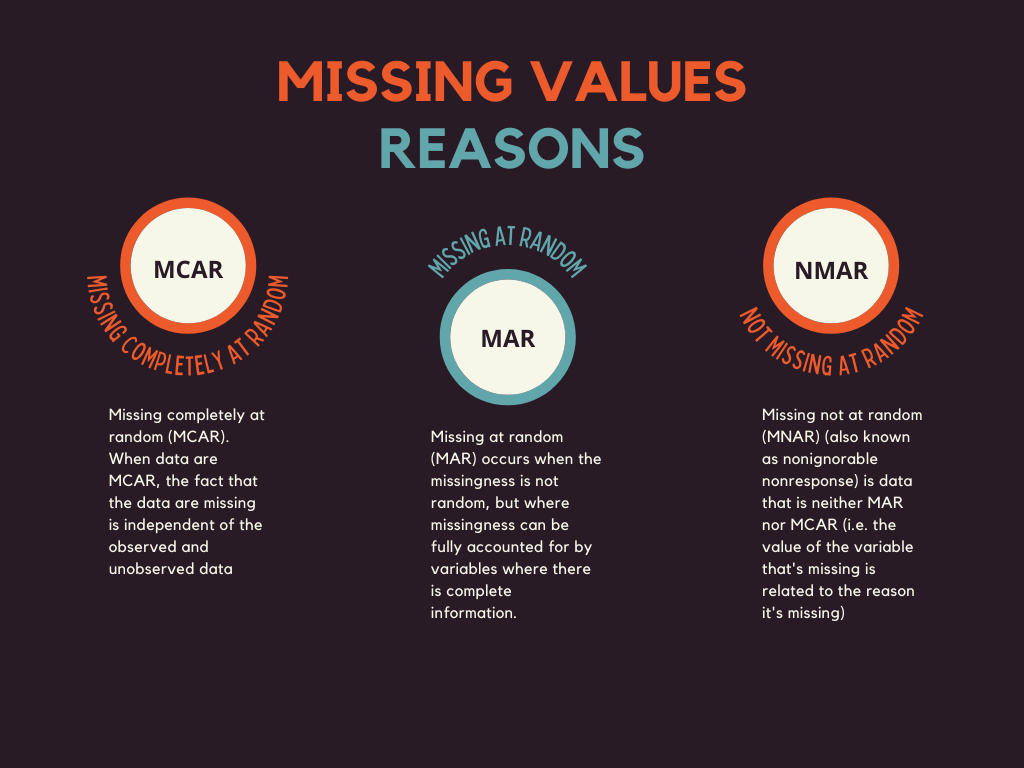

<AxesSubplot:>

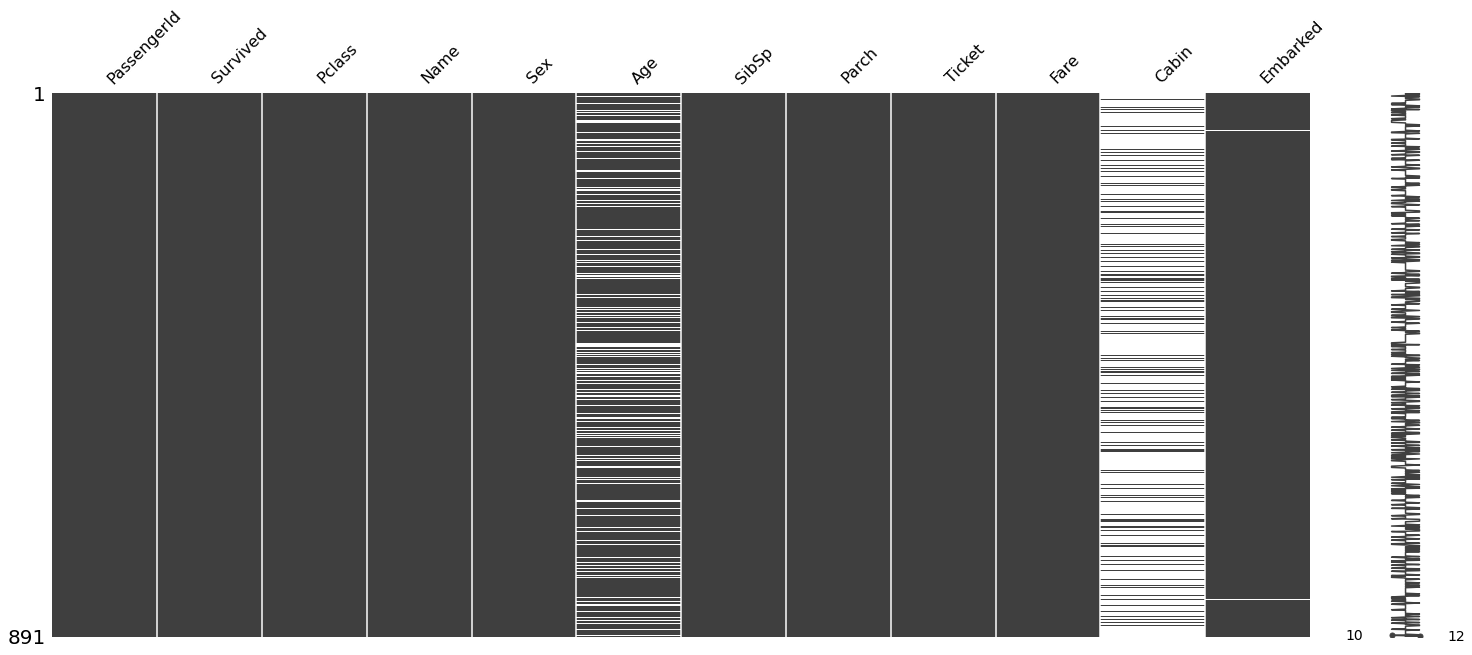

In [123]:
msno.matrix(train_samples)

Whitelines represent missing values and black one is notnull and there are some sparklines towards the right indicate the completeness of data. Still by seeing this we can figure out completeness but not the relation right, so let's zoom in a little bit and also we will try sorting these values to see how correlated these were

<AxesSubplot:>

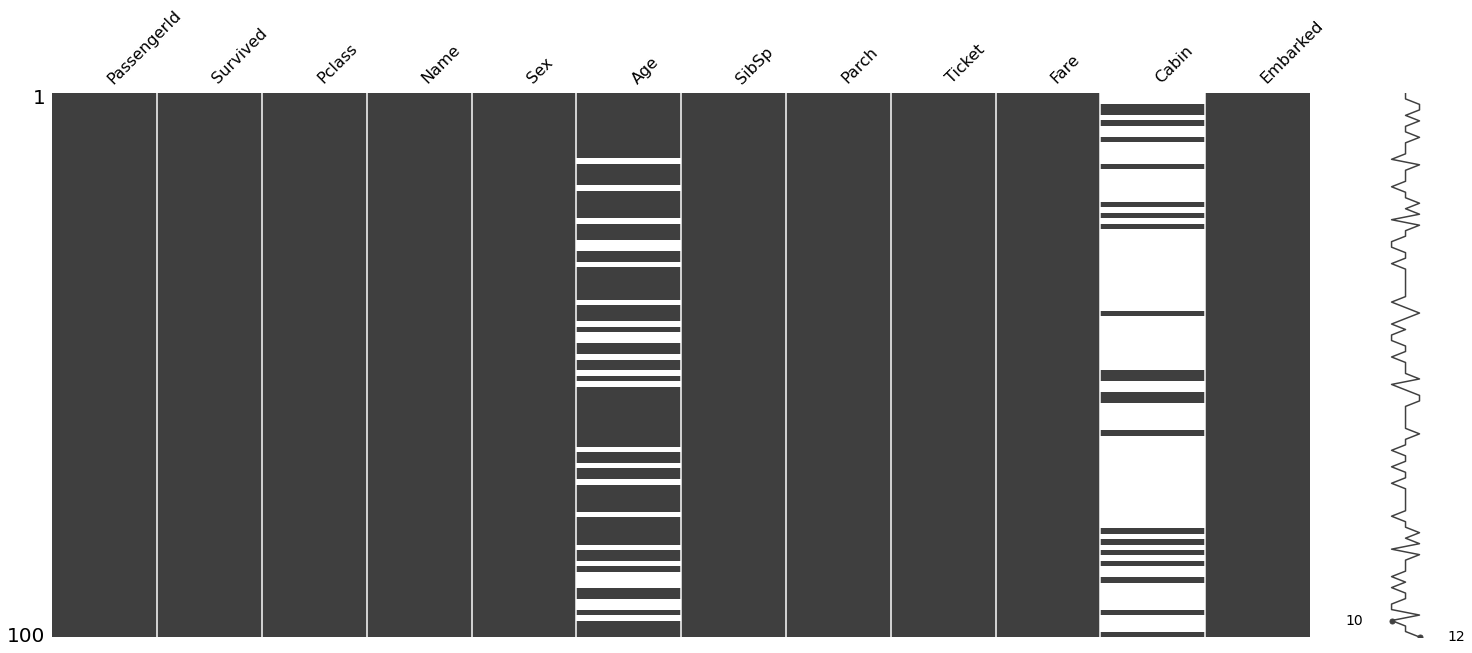

In [124]:
msno.matrix(train_samples.sample(100))

<AxesSubplot:>

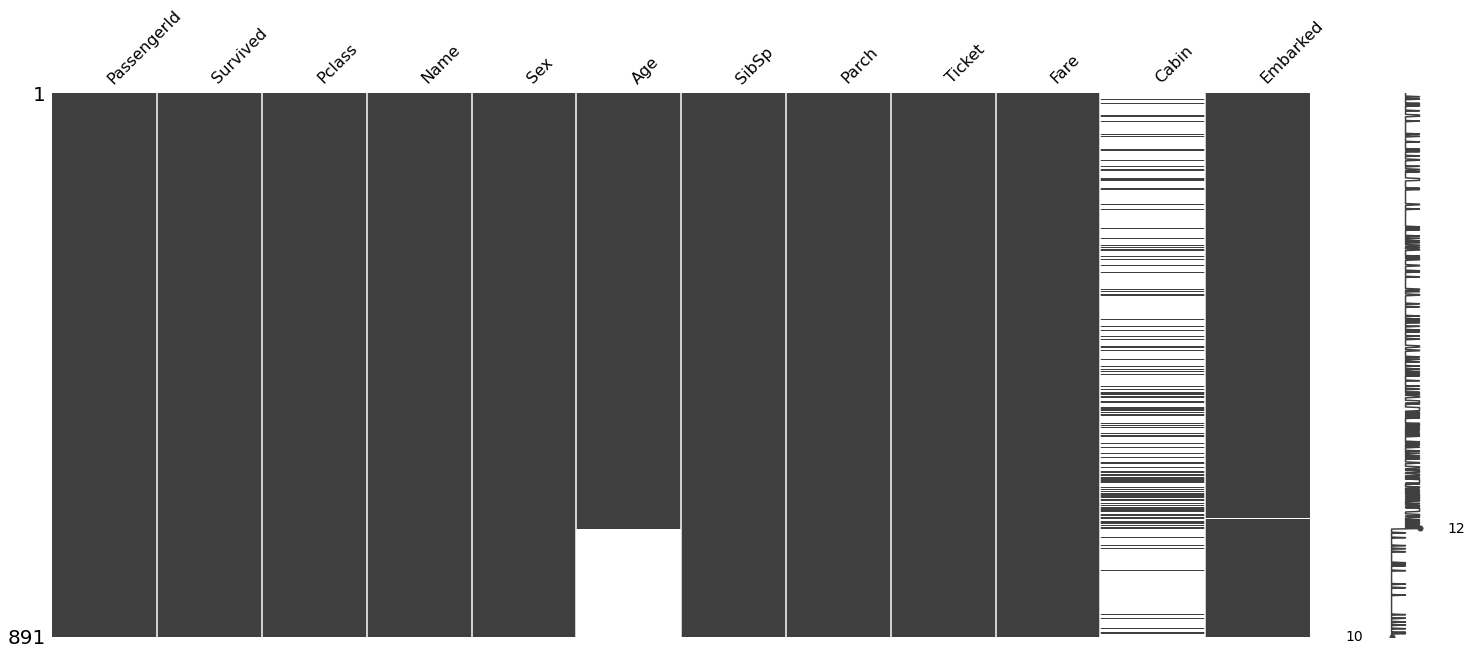

In [125]:
#Let's just sort our df by age and see how these values are correlated
sorted_by_age = train_samples.sort_values('Age')
msno.matrix(sorted_by_age)

## Finding missing values correlation using heatmap and dendrogram from missingno

<AxesSubplot:>

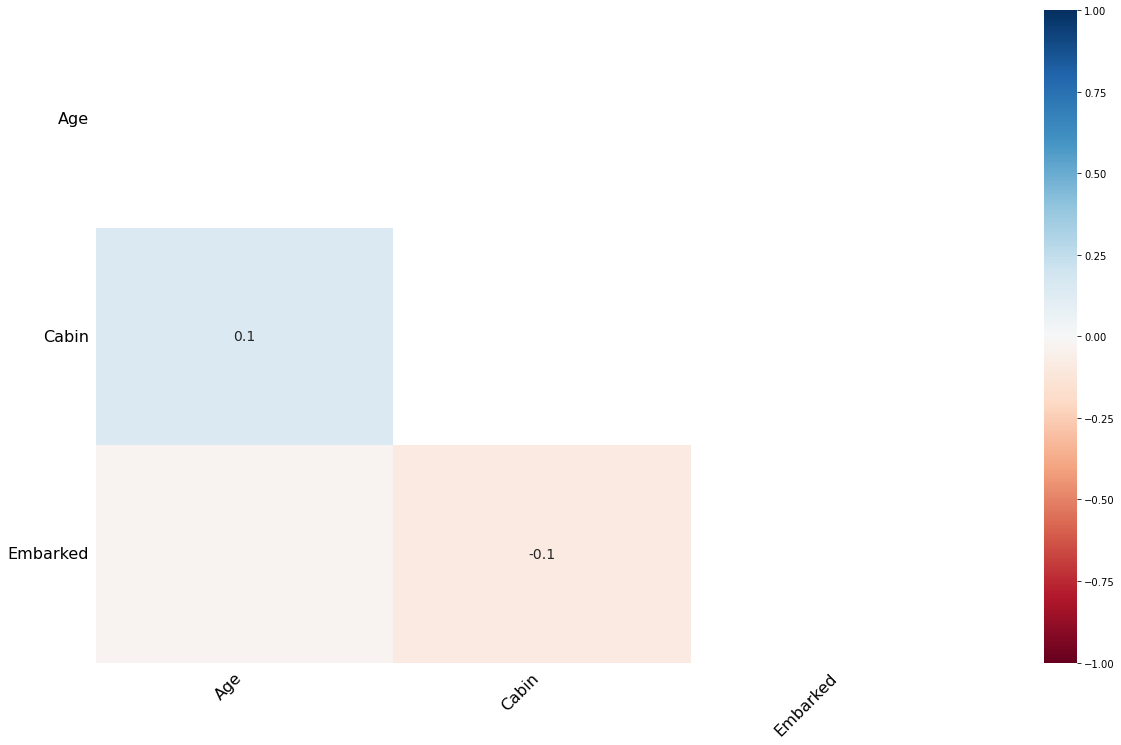

In [126]:
msno.heatmap(train_samples)

Nullity correlation ranges from -1 (if one variable appears the other definitely does not) to 0 (variables appearing or not appearing have no effect on one another) to 1 (if one variable appears the other definitely also does).

From the above diagram we can say that these features are not much correlated So, let's check it further using dendrogram.

<AxesSubplot:>

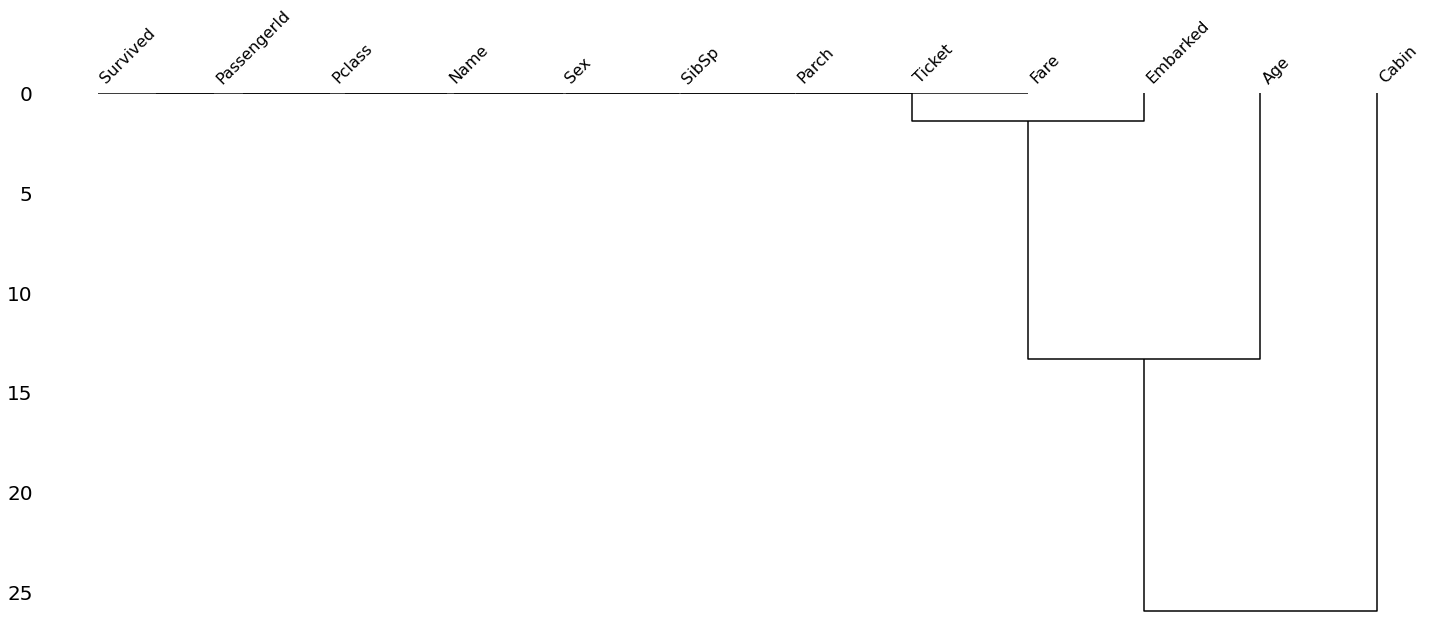

In [127]:
#The dendrogram allows you to more fully correlate variable completion, revealing trends deeper than the 
#pairwise ones visible in the correlation heatmap
msno.dendrogram(train_samples)

Note:To better understand dendrogram and how to interpret the diagram please have a look at this <a href="https://www.displayr.com/what-is-dendrogram/#:~:text=The%20key%20to%20interpreting%20a,objects%20are%20A%20and%20B.">link</a>.

From the diagram, we can say that <b>Ticket</b> and <b> Embarked</b> are more related than <b>Embarked</b> and <b>Age</b> than <b>Age</b> and <b>Cabin</b>. But from here we can say that this correlation high due to insignificant portion of values are missing from embarked

## Deletion of Missing Values

To delete these values we can either use deletions such as litwise(deleting entire row) or dropping complete columns 

In [128]:
train_samples.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [129]:
train_samples_copy = train_samples.copy()

### Litwise Deletion
During Litwise deletion complete row(complete case with missing values) are deleted which can have impact to other values because a major portion of records are deleted  hence more information lost, this is mostly used in case of MCAR

In [130]:
train_samples_copy.dropna(subset=['Age'], how='any', inplace=True)
train_samples_copy.Age.isnull().sum()

0

### Dropping Complete column

If any columns in your dataset is not containing more than 75- 80% of data or missing values then we treat it as insignificant attribute and may even consider deleting it, but data is what our model relies on so depending on correlation we can either impute some values or delete it.

## Imputing Techniques

Imputation refer to filling these missing values, this can be done depending on nature of problem we are dealing with.

### Basic Imputing Techniques

- Imputing with a constant
- Imputing using statistics(Mean/Median/Mode)

Here to demonstrate I'll use ```The Simple Imputer``` from ```sklearn```

In [131]:
#replacing with constant
train_samples_constants = train_samples.copy()

constant_imputer = SimpleImputer(strategy='constant')
train_samples_constants.iloc[:,:] = constant_imputer.fit_transform(train_samples_constants)
train_samples_constants.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [132]:
#strategy can also be mean or median, here let's replace with most frequent

train_samples_frequent = train_samples.copy()

frequent_imputer  = SimpleImputer(strategy='most_frequent')
train_samples_frequent.iloc[:,:] = frequent_imputer.fit_transform(train_samples_frequent)
train_samples_frequent.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64